# Birdcall Identification
Here I hope to be able to make a model to predict the type of bird based on metadata sourced from recordings of birdcalls, including location, date/time, and frequency data extracted from Discrete Fourier Transformation and frequency spectrograms from Short Term Fourier Transformations.


We will be making use of a few different libraries outside of the normal anaconda distrobution. We will only install individual dependencies used in this project here. I use a rebuild of conda called micromamba to organize my virtual enviroment, but you can replace `micromamba` with `conda` in any command I use to do the same thing with a traditional anaconda distrobution.
```bash
micromamba create -p ./.conda ipykernel pandas numpy scipy matplotlib cupy ffmpeg
micromamba activate ./.conda
pip install pydub
```

`ipykernel`, `pandas`, `numpy`, `scipy`, and `matplotlib` are all part of anaconda.
`cupy` is a remake of `numpy` and `scipy` that makes use of nvidias cuda toolkit to perform calulations on the gpu with cuda capable cpus.
`ffmpeg` is a tool for converting and decoding a variety of different audio and video codecs that will be used to decoding mp3 files.
`pydub` is a python library for dealing with audio files in a shorthand manner. `pydub` uses `ffmpeg` automatically for mp3 decoding if it is avaliable.

## Importing and Understanding our data

### Downloading Data
The first data source is from a [kaggle competition](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/), and has most of the data preorganized for us. This can also be downloaded by running this code after accepting the terms of the competition on a valid kaggle account:
```bash
kaggle competitions download -c birdsong-recognition
```

The Dataset includes in it a large set of mp3 files organized by individual bird. each bird is assigned an ebird code, this appears to be something widly used by the Cornell Lab of Ornithology where this data originated, and the mp3 files are organized in folders with their ebird code. The file train.csv contains information about the mp3 files.

```log
.
├── example_test_audio
│  ├── BLKFR-10-CPL_20190611_093000.pt540.mp3
│  └── ORANGE-7-CAP_20190606_093000.pt623.mp3
├── example_test_audio_metadata.csv
├── example_test_audio_summary.csv
├── sample_submission.csv
├── test.csv
├── train.csv
└── train_audio
   ├── aldfly
   │  ├── XC2628.mp3
   │  └── ...
   ├── ameavo
   │  ├── XC99571.mp3
   │  └── ...
   ├── amebit
   │  ├── XC127371.mp3
   │  └── ...
   ├── amecro
   │  ├── XC51410.mp3
   │  └── ...
   ├── amegfi
   │  ├── XC17120.mp3
   │  └── ...
   ├── amekes
   │  ├── XC16111.mp3
   │  └── ...
   └── ...
```

In [1]:
import time
import os
import asyncio
import sys
import pandas as pd
import numpy as np
import scipy as sp
import cupy as cp
import cupyx as cpx
import cupyx.scipy.fft as cufft
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.utils import mediainfo

In [2]:
df = pd.read_csv('data/birdsong-recognition/train.csv')
df.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


While this does list the individual species of the bird, it doesnt give me the full taxonomy of the bird in the file. I expect the number of indidual species of birds here to be very high which will make if more difficult to train a classification model on.

In [3]:
df.species.nunique()

264

So I would like the option to be able to detect something less specific than the actual species, if I could detect the correct order or family of bird that could still prove valuable and would have a smaller sample of options to classify. I searched for a dataset of species of birds with their full taxonomy, and I found [this](https://www.birds.cornell.edu/clementschecklist/introduction/updateindex/october-2023/download/) dataset that seems to be from the same organization that put together the birdsong data.

In [4]:
taxonomy = pd.read_csv('data/ebird_taxonomy_v2023.csv')
taxonomy.head()

,TAXON_ORDER,CATEGORY,SPECIES_CODE,TAXON_CONCEPT_ID,PRIMARY_COM_NAME,SCI_NAME,ORDER,FAMILY,SPECIES_GROUP,REPORT_AS
0,2,species,ostric2,avibase-2247CB05,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,7,species,ostric3,avibase-40329BB6,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
2,8,slash,y00934,avibase-5D14080C,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
3,10,species,grerhe1,avibase-00986B24,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,16,species,lesrhe2,avibase-590ADF92,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),Rheas,NaN


From here because we know we are dealing with a lot of data, even though we are still in the early stages before things start getting out of hand, I'm going to begin tracking how much data is contained in our dataframes, just so we can see when things are getting unruly.

In [5]:
def memory_usage(name, df):
    memory = df.memory_usage(deep=True).sum()
    print(f'{name} Memory Usage: {bytes_to_human_readable(memory)}')

def bytes_to_human_readable(n):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if n < 1024:
            return f"{n:.2f} {unit}"
        n /= 1024
    return f"{n:.2f} PB"

In [6]:
memory_usage('Training Data', df)
memory_usage('Taxonomy', taxonomy)

Training Data Memory Usage: 44.54 MB
Taxonomy Memory Usage: 9.36 MB


Its worth noting, this is roughly 3.5 times more data than the raw csv alone. We will want to keep an eye on this

### Veryifying the datasets match
Before we begin perminantly combining these datasets, first lets verify that these data sets are compatible with eachother. First Lets make sure the `SPECIES_CODE` column contains only unique values. This dataset contains more than just species, and I want to know for sure that one species has a unique species code.

In [7]:
total_species_codes = len(taxonomy['SPECIES_CODE'])
unique_species_codes = taxonomy['SPECIES_CODE'].nunique()
print('All values in SPECIES_CODE are unique:', total_species_codes == unique_species_codes)
del total_species_codes, unique_species_codes
    

All values in SPECIES_CODE are unique: True


Now I'll make sure that for the `SPECIES_CODE` column in the `taxonomy` dataframe refers to the same `ebird_code` listed by the main dataframe. To do this I will make sure that the when the `taxonomy.SPECIES_CODE` and `df.ebird_code` match that the `taxonomy.SCI_NAME` and `df.sci_name` also match.

To make this computation happen faster, I'm going to merge the two dataframes on that `ebird_code` column, that way we only need to iterate through the dataframe once to be able to check the needed files.

In [8]:
# Merge the taxonomy data with the training data
df = df.merge(taxonomy, left_on='ebird_code', right_on='SPECIES_CODE', how='left', indicator=True)
# Get the ebird_codes that did not merge or have a scientific name mismatch between the two datasets
bad_codes = df[(df['_merge'] == 'left_only') | (df['sci_name'] != df['SCI_NAME'])]['ebird_code'].unique()

# Iterate through the bad codes and print out the scientific names that do not match
for code in bad_codes:
    if code not in taxonomy['SPECIES_CODE'].values:
        print(code, "not found in taxonomy")
    else:
        sci_name_mismatch = df[(df['ebird_code'] == code) & (df['sci_name'] != df['SCI_NAME'])]
        for _, row in sci_name_mismatch.iterrows():
            print(code, "SCI_NAME mismatch")
            print(row['SCI_NAME'], '!=', row['sci_name'])
            print("Row number:", row.name)

print("Bad codes:", bad_codes)
del bad_codes

doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7087
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7088
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7089
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7090
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7091
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7092
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7093
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7094
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7095
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7096
doccor SCI_NAME mismatch
Nannopterum auritum != Phalacrocorax auritus
Row number: 7097
doccor SCI_NAME mismatch
Nannopterum auritu

While that did print out a lot of individual problem rows, there were only 5 indivudal codes that did not seem to match: 
`['doccor' 'evegro' 'haiwoo' 'pasfly' 'ruckin']`

Upon manual examination I found that while the two datasets disagree over the scientific name, they do all agree on the common name for the bird. As well when looking up the birds on wikipedia, in all cases I found one of the listed scientific names under the 'Synonyms' section. The important thing is not which name is 'correct', but just that the `ebird_code` and `SPECIES_CODE` are refering to the same thing, which we have proven here. 

Since we know the codes refer to the same species of bird, we can completely ignore all of the species information from the original dataframe and only use the species information from the taxonomy dataset, because it contains more useful information for our needs.

### Understanding our Merged Data

In [9]:
print(df.columns)
memory_usage('Merged Data', df)

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license', 'TAXON_ORDER', 'CATEGORY', 'SPECIES_CODE',
       'TAXON_CONCEPT_ID', 'PRIMARY_COM_NAME', 'SCI_NAME', 'ORDER', 'FAMILY',
       'SPECIES_GROUP', 'REPORT_AS', '_merge'],
      dtype='object')
Merged Data Memory Usage: 55.96 MB


In [10]:
df = df.drop(columns=['_merge', 'playback_used', 'pitch', 'speed',
                      'species', 'number_of_notes', 'title', 'secondary_labels',
                      'bird_seen', 'sci_name', 'location', 'description',
                      'bitrate_of_mp3', 'volume', 'background', 'xc_id',
                      'url', 'country', 'author', 'primary_label',
                      'length', 'recordist', 'license', 'TAXON_ORDER',
                      'CATEGORY', 'SPECIES_CODE', 'TAXON_CONCEPT_ID', 'REPORT_AS'])
df.rename(columns={'PRIMARY_COM_NAME': 'common_name', 
                   'SCI_NAME': 'sci_name', 
                   'ORDER': 'order', 
                   'FAMILY': 'family', 
                   'SPECIES_GROUP': 'species_group'}, inplace=True)
print(df.columns)
memory_usage('Merge Data', df)
del taxonomy

Index(['rating', 'ebird_code', 'channels', 'date', 'duration', 'filename',
       'latitude', 'sampling_rate', 'type', 'elevation', 'file_type',
       'longitude', 'time', 'common_name', 'sci_name', 'order', 'family',
       'species_group'],
      dtype='object')
Merge Data Memory Usage: 20.00 MB


What we are left with is a dataframe with only features that intuitively feel like they may be valuable for a model to train off of or may be useful to us in other orginizational ways:
 - `rating`: It may prove to be valuable to filter out some less desirable files in the training data. This may be a good feature to filter by
 - `ebird_code`: This is a potential target to train a model to classify. This will have an individual value for every species
 - `channels`: This may be needed when normalizing data from audio files
 - `date`: Some birds may be more likely to be heard in specific times of the year. The date of the recording may provide some insite on the types of birds that are most likely to be heard
 - `duration`: This may prove to be useful to keep in the data for calculations that arent directly tied to features.
 - `filename`: This will be needed to access data about the waveform itself.
 - `latitude`/`longitude`: These two features in conjunction with eachother could provide helpful insite based on which birds are present where.
 - `sampling_rate`: This may be useful for metadata when performing foyer transformations to ensure that frequency maps display correctly.
 - `type`: This is the type of sound that is being heard, ie a call, or drumming, or a scream. This would probably need to be cleaned up or engineered in some way but could be helpful in conjunction with frequency data to help understand what is being listened for. (This however is not something that could be given as easily as a predictor)
 - `elevation`: This could potentially have similar value to latitude and longitude, and may be used as a 3rd axis in that group.
 - `file_type`: This may be nessicary when organizing data files and making sure they are displaying the same as eachother.
 - `time`: This refers to the time of day of the recording. This may be useful training data because some calls may be more likely to happen at specific times of the day.
 - `common_name`: This should be 1 to 1 with ebird_codes, and could provide the same use, but with a human readable and understandable output.
 - `sci_name`: This matches the values of the common_name
 - `family`: This is the family that the species belongs to. This is a potential target that has fewer unique values than trying to target an individual species
 - `order`: This is the order that the species belongs to. This is a potential target that has fewer unique values than trying to target a family of species.
 - `species_group`: This is the human understandable group that the species belong to. In many cases I believe this actually follows the family but is human readable and understandable.

For all of the potential targets, lets print out how many unique values there are so we know how many individual classifers we will need.

In [11]:
print('common_name:', df['common_name'].nunique())
print('sci_name:', df['sci_name'].nunique())
print('order:', df['order'].nunique())
print('family:', df['family'].nunique())
print('species_group:', df['species_group'].nunique())

common_name: 264
sci_name: 264
order: 17
family: 50
species_group: 45


Each of these represent potential targets for our classification model. Detecting for each unique species is ideal but has 264 possible outputs. Detecting Species groups is very human understandable and still useful, and only contains 45 options, but that is still a lot. Detecting the Order has only 17 possible outputs, but the birds also may prove to be less and less correlated to eachother in terms of call.

### Working with audio
Most of the audio data can be manipulated with the pydub library, especially since we are given mp3 files and not something lossless.

In [12]:
file_path = 'data/birdsong-recognition/train_audio/aldfly/XC2628.mp3'
bird_sound = AudioSegment.from_file(file_path, format=mediainfo(file_path)['format_name'])
del file_path

# Print the length of the audio file in milliseconds
print(f'Length: {len(bird_sound)}')

# Print the sample rate of the audio file
print(f'Sample Rate: {bird_sound.frame_rate}')

# Print the number of channels in the audio file
print(f'Channels: {bird_sound.channels}')

# Print the Bit Depth of the audio 
# This is not accessable from the sound file itself, and is found from pydub.utils import mediainfo
print(f'Bit Depth: {mediainfo("data/birdsong-recognition/train_audio/aldfly/XC2628.mp3").get('sample_fmt', '')}')

new_sound = bird_sound[500:1500] + bird_sound[500:1500] + bird_sound[500:1500] + bird_sound[500:1500] + bird_sound[500:1500]
new_sound.export("exports/preview1.wav", format="wav")
del new_sound

Length: 15256
Sample Rate: 44100
Channels: 1
Bit Depth: fltp


This now provides a very simple playback system for working with audio data. the AudioSegment object are immutable and have a very simple syntax for basic operations. Audio can be spliced like this a python list, where the index marks the number of miliseconds from the start of the file, Audio can also be concatinated with other audio with a simple `+` operator, but all changes must be written to another variable because All AudioSegment objects are immutable.

Sound can be played with the library simpleaudio installed but we can preview all audio in browser so it is accessable to the reader without setting up the enviroment.
Here is the audio file loaded in the `sound` variable

<audio controls>
  <source src="https://xeno-canto.org/sounds/uploaded/KOIEAHGHNX/79/b07.mp3" type="audio/mpeg">
Your browser does not support the audio element, but trust my the audio played back and it sounded like a bird.
</audio>

And here is the audio file we made from `new_sound`

<audio controls>
  <source src="exports/preview1.wav" type="audio/wav">
Your browser does not support the audio element, but trust my the audio played back and it sounded like a bird.
</audio>

### Verifying all Data

In [13]:
# Function to print a progress bar that updates in place
def print_progress_bar(iteration, length, message='', convert_to_human_readable=False):
    progress = iteration / length
    progress = int(progress * 100)
    # Determine color based on progress
    if progress < 50:
        color = '\033[91m'  # Red
    elif progress < 100:
        color = '\033[93m'  # Yellow
    else:
        color = '\033[92m'  # Green
    bar = color + '=' * progress + '\033[0m' + ' ' * (100 - progress)
    #print('\033[?25l', end='')  # Hide cursor - causes issues in Jupyter
    if convert_to_human_readable:
        iteration = bytes_to_human_readable(iteration)
        length = bytes_to_human_readable(length)
    if message:
        message = f'\r[{bar}] - {iteration}/{length} - {message}'
    else:
        message = f'\r[{bar}] - {iteration}/{length}'
    print(message, end='', flush=True)
    if progress == 100:
        print()
        #print('\033[?25h', end='')  # Show cursor - causes issues in Jupyter
    #else:
        #print('\033[?25h', end='')  # Show cursor after each update - causes issues in Jupyter

def calculate_time_remaining(start_time, iteration, length):
    elapsed_time = time.time() - start_time
    iterations_remaining = length - iteration
    time_per_iteration = elapsed_time / iteration
    time_remaining = iterations_remaining * time_per_iteration
    hours, rem = divmod(time_remaining, 3600)
    minutes, seconds = divmod(rem, 60)
    time_remaining_str = f'{int(hours):02}:{int(minutes):02}:{int(seconds):02}'
    return time_remaining_str

def print_boundry(message):
    length = (100 - len(message)) // 2
    print('-' * length, message, '-' * length)

def get_audio(bird, file):
    try:
        file_path = f'data/birdsong-recognition/train_audio/{bird}/{file}'
        sound = AudioSegment.from_file(file_path, format=mediainfo(file_path)['format_name'])
        return bird, file, sound
    except:
        print(f'Error loading {bird}/{file}', end='\033[K')
        return bird, file, None

async def decompress_audio(bird, file):
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, get_audio, bird, file)

async def process_files(bird, files):
    tasks = [decompress_audio(bird, file) for file in files]
    return await asyncio.gather(*tasks)

In [14]:
print_boundry('Processing Audio Files')
start_time = time.time()
total_count = 0
bird_count = 0
# Create a new dataframe with all the columns from the original dataframe
df.rename(columns={'channels': 'channel'}, inplace=True)
new_df = pd.DataFrame(columns=df.columns)
# Add the collumn bit rate to the dataframe
old_records = None
if os.path.exists('exports/audio.csv'):
    old_records = pd.read_csv('exports/audio.csv')
    new_df = old_records.copy()
new_df['bit_depth'] = np.nan
new_df['array_size'] = np.nan
for bird in df['ebird_code'].unique():
    bird_count += 1
    count = 0
    bird_time = time.time()
    # If csv file already exists, skip the bird
    if old_records is not None:
        if bird in old_records.ebird_code.unique():
            total_count += len(df[df.ebird_code == bird])
            message = f'{bird} - {bird_count}/{len(df.ebird_code.unique())}'
            print_progress_bar(len(df[df.ebird_code == bird]), len(df[df.ebird_code == bird]), message=message)
            continue
    for bird, file, sound in await process_files(bird, df[df['ebird_code'] == bird].filename.values):
        count += 1
        total_count += 1
        if sound is None:
            continue
        for i in range(sound.channels):
            row = df[(df.ebird_code == bird) & (df.filename == file)].iloc[0].copy()
            row.filename = f'data/birdsong-recognition/train_audio/{bird}/{file}'
            row.channel = i
            row.duration = len(sound) / 1000
            row.sampling_rate = sound.frame_rate
            row['bit_depth'] = mediainfo(row.filename).get('sample_fmt', '')
            mono_sound = sound.split_to_mono()[i]
            row['array_size'] = np.array(mono_sound.get_array_of_samples()).nbytes
            new_df.loc[len(new_df)] = row
        message = f'{calculate_time_remaining(bird_time, count, len(df[df.ebird_code == bird]))} - {bird} - {bird_count}/{len(df.ebird_code.unique())} - {calculate_time_remaining(start_time, total_count, len(df))}'
        print_progress_bar(count, len(df[df.ebird_code == bird]), message=message)
    new_df.to_csv('exports/audio.csv', index=False)

time_to_complete = time.time() - start_time
print_boundry('Complete')

del start_time, total_count, bird_count, bird_time, count, new_df, old_records, df
df = pd.read_csv('exports/audio.csv')

--------------------------------------- Processing Audio Files ---------------------------------------
[====================================================================================================] - 100/100 - aldfly - 1/264
[====================================================================================================] - 38/38 - ameavo - 2/264
[====================================================================================================] - 44/44 - amebit - 3/264
[====================================================================================================] - 100/100 - amecro - 4/264
[====================================================================================================] - 100/100 - amegfi - 5/264
[====================================================================================================] - 75/75 - amekes - 6/264
[====================================================================================================] - 100/100 - amepip -

[====================================================================================================] - 33/33 - amewig - 10/264
[====================================================================================================] - 83/83 - amewoo - 11/264
[====================================================================================================] - 74/74 - amtspa - 12/264
[====================================================================================================] - 100/100 - annhum - 13/264
[====================================================================================================] - 100/100 - astfly - 14/264
[====================================================================================================] - 55/55 - baisan - 15/264
[====================================================================================================] - 35/35 - baleag - 16/264
[============================================================================================

This took 55 minutes to run on a machine with an Intel Core i5 9600K processor. This tells me that the act of decoding MP3 files will prove to be quite a heavy bottleneck in performance.

## Feature Engineering

### Fourier Transformations

To extract information about the frequencies within a waveform, we can use a Fourier Transformation. A Fourier Transformation is a function that converts an array of amplitude values in a signal into an array of complex values representing the magnitude and phase of the frequencies within the signal.



### Performing Calulations on the GPU with Cuda and CuPy

Cupy is a library that duplicated almost all of numpy and scipy to make use of nvidias Cuda Toolkit. We will run everything on the GPU, knowing we may have slightly worse performance when doing smaller batches of processes because of the bottleneck of transferring data in and out of GPU memory. GPU processing with Cuda is a little bit more complicated than how we would normally do it but I expect many of these processes to take multiple hours to process and getting GPU processing working early will be remarkably helpful. Plus Cuda has tools specifically for performing Fast Fourier Transformations on the GPU, so I know these tools are capable of large acceleration.

To begin we need to make sure our enviroment allocated vram for this specific functionality. MP3 encoding is capable of filesize compression well past 10:1, meaning with 25 gigs of mp3 files we can have well over 250 gigs of uncompressed waveform data. We can easily fill our ram completely if we are not careful, and in most cases if we are using vram specifically we have even less.



In [15]:
print('Total memory in waveforms to be processed:', bytes_to_human_readable(df['array_size'].sum()))

Total memory in waveforms to be processed: 140.28 GB


I have 2 options for machines to run this notebook on.

Machine 1:
 - CPU: Intel Core i5-9600k
   - Cores: 6
   - Threads: 6
   - Base Frequency: 3.70GHz
 - GPU: Nvidia GeForce RTX 2060
   - VRAM: 6 GB
   - Cuda Cores: 1920
   - Tensor Cores: 240
   - Base Clock Speed: 1365 MHz
 - RAM: 64 GB

Machine 2:
 - CPU: 
   - Cores:
   - Threads:
   - Base Frequency:
 - GPU: Nvidia GeForce RTX 4080
   - VRAM: 16 GB
   - Cuda Cores: 9728
   - Tensor Cores: 304
   - Base Clock Speed: 2205 MHz
 - RAM: 64 GB

Most of the tests will be run on machine 1 but more intensive processes I can run machine 2. We will allocate 75% of our avaliable VRAM to memory, that way when we go over that amount we get an explicit crash.

In [16]:
# Get the GPU device. All of the machines I have access to have a single GPU, but cupy can handle multiple GPUs.
gpu = cp.cuda.Device(0)
gpu.use()

# Set the memory pool limit to 75% of the total VRAM
vram_pool = cp.get_default_memory_pool()
with gpu:
    vram_pool.set_limit(fraction=0.75)

#### Normalizing Amplitudes

We will normalize all signal values to between 1 and -1 where 1 is equal to the max signal amplitude in the file. This normally would be normalized based on the maximum integer or float values in the bit depth of the file but we in this case are making a conscious decision to normalize based on the maximum amplitude in the file. This maximizes the volume and normalizes most of the audio files such that they are around the same scale.

We will also build a function that converts all amplitude values from their traditional madnitude scaling (without accounting for phase) into decibels. A decebel is a logorithmic scale used in audio frequently that is more accurately scaled to human perception of audio. We will be apply the following formula to each element in the array given to calulate decibels.

$
\Huge
dB = 20 \cdot \log_{10}(|X[k]|+\epsilon)
$

Where X is our array magnitude values, usually in the form of an array of complex values resulting in a fourier transformation

$
\Huge
[ X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-j \frac{2\pi}{N} kn} ]
$




In [17]:
def normalize_signal(signal):
    if not isinstance(signal, cp.ndarray):
        signal = cp.array(signal, dtype=cp.float32)
    max_amplitude = cp.max(cp.abs(signal))
    return signal / max_amplitude

def magnitude_to_db(signal, epsilon=sys.float_info.epsilon):
    return 20 * cp.log10(cp.abs(signal) + epsilon)

In [18]:
print('Max:', cp.max(normalize_signal(bird_sound.get_array_of_samples())))
print('Min:', cp.min(normalize_signal(bird_sound.get_array_of_samples())))

Max: 0.9337139
Min: -1.0


In [19]:
def hz_to_mel(hz):
    return 2595 * cp.log10(1 + hz / 700)

def mel_to_hz(mel):
    return 700 * (10 ** (mel / 2595) - 1)

def hz_to_erbs(hz):
    return 21.4 * cp.log10(0.00437 * hz + 1)

def erbs_to_hz(erbs):
    return (10 ** (erbs / 21.4) - 1) / 0.00437

def hz_to_bark(hz):
    return 6 * cp.arcsinh(hz / 600)

def bark_to_hz(bark):
    return 600 * cp.sinh(bark / 6)

def plot_frequencies(frequencies, freq_signal, scale='bark', title='Spectrum', xlabel='Frequency (Hz)', ylabel='Amplitude (dB)'):
    if not isinstance(frequencies, cp.ndarray):
        frequencies = cp.asarray(frequencies, dtype=cp.float32)
    xticks = cp.array([20, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])
    if cp.max(freq_signal) > 0:
        print('Amplitude values must be negative for dBFS')
        return
    if scale not in ['log', 'mel', 'bark', 'erbs']:
        print('Invalid scale')
        return
    plt.figure(figsize=(12, 6))
    plt.title(title)
    plt.xlabel(xlabel + f' ({scale})')
    plt.ylabel(ylabel)
    scale_function = None
    if scale == 'log':
        scale_function = lambda x: x
        plt.xscale('log')
    if scale == 'mel':
        scale_function = hz_to_mel
        plt.xscale('linear')
    if scale == 'bark':
        scale_function = hz_to_bark
        plt.xscale('linear')
    if scale == 'erbs':
        scale_function = hz_to_erbs
        plt.xscale('linear')
    plt.xlim(scale_function(20), scale_function(20000))
    plt.xticks(scale_function(xticks).get(), xticks.get())
    plt.ylim(-110, 0)
    plt.yticks([0, -20, -40, -60, -80, -100], 
               [0, -20, -40, -60, -80, -100])
    if isinstance(freq_signal, cp.ndarray):
        freq_signal = freq_signal.get()
    plt.plot(scale_function(frequencies).get(), freq_signal)
    plt.grid(True, which="both", axis='x', ls="--")
    plt.show()

def fourier_transform(sound, cache=False):
    if sound.channels > 1:
        sound = sound.split_to_mono()[0]
    signal = normalize_signal(sound.get_array_of_samples())
    if cache:
        signal = cufft.rfft(signal, overwrite_x=True)
    else:
        with cufft.get_fft_plan(signal, value_type='R2C'):
            signal = cufft.rfft(signal, overwrite_x=True)
    n = sound.frame_count()
    signal = signal / (n/2)
    frequencies = cufft.rfftfreq(n, 1/sound.frame_rate)
    return frequencies, magnitude_to_db(signal)

def plot_fourier_transformation(sound, scale='bark'):
    frequencies, freq_signal = fourier_transform(sound)
    plot_frequencies(frequencies, freq_signal, scale=scale)

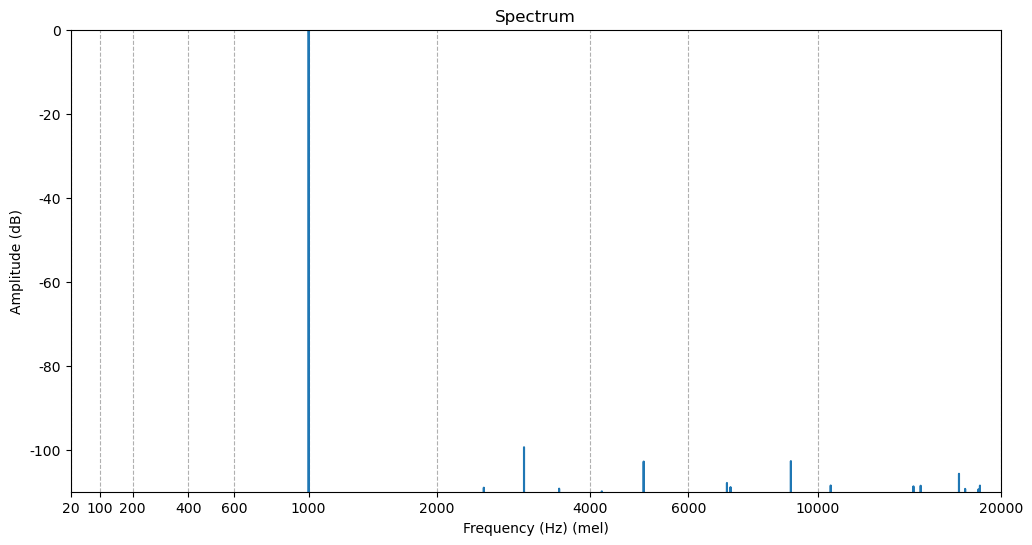

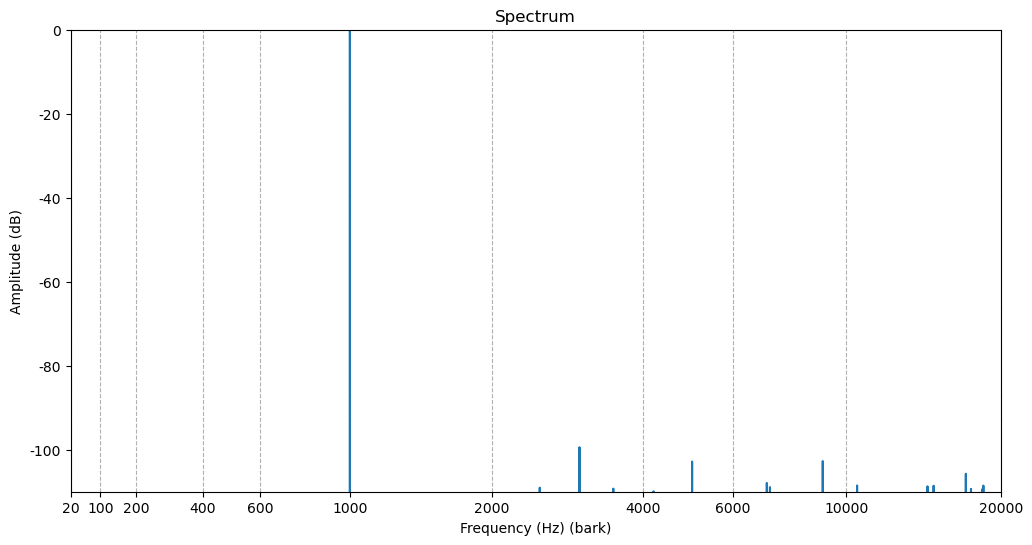

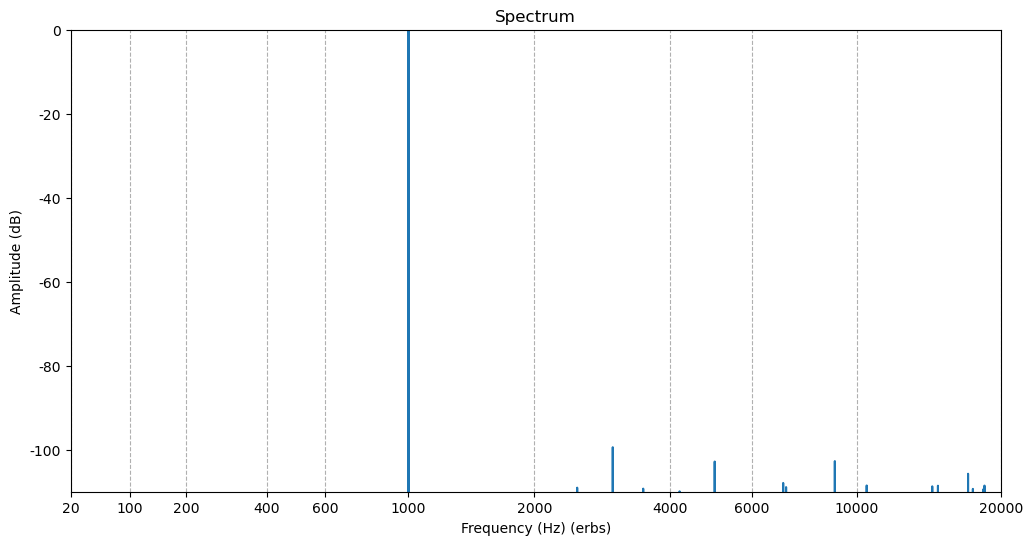

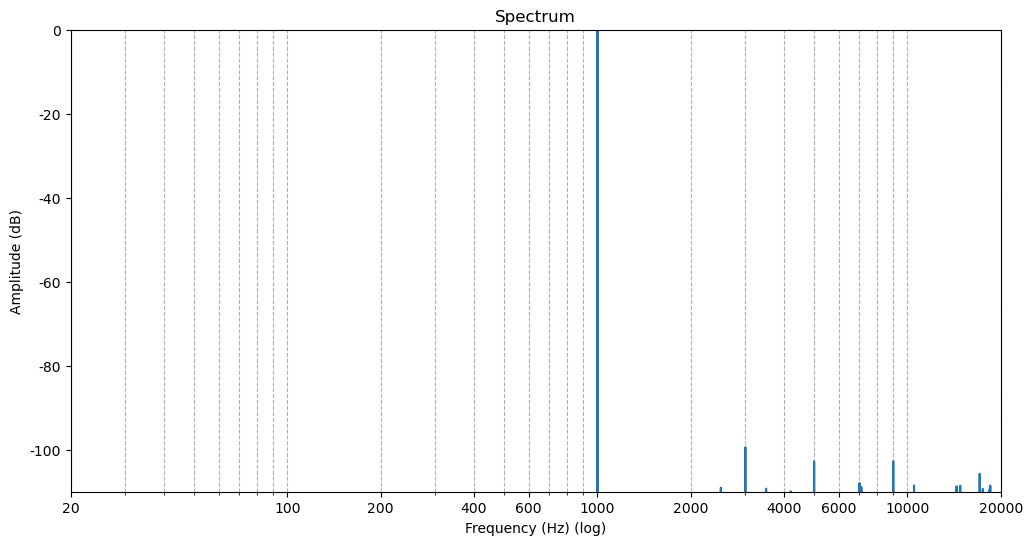

In [20]:
def generate_sine_wave(frequency, duration, sample_rate=44100, amplitude=0.5):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = amplitude * np.sin(2 * np.pi * frequency * t)
    waveform = np.int16(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

sine_wave = generate_sine_wave(1000, 1)
sine_wave.export("exports/sine_wave.wav", format="wav")
plot_fourier_transformation(sine_wave, scale='mel')
plot_fourier_transformation(sine_wave, scale='bark')
plot_fourier_transformation(sine_wave, scale='erbs')
plot_fourier_transformation(sine_wave, scale='log')
del sine_wave

#### Explerimenting with different waveforms

$[ \text{dB} = 20 \cdot \log_{10}(|X[k]|) ]$



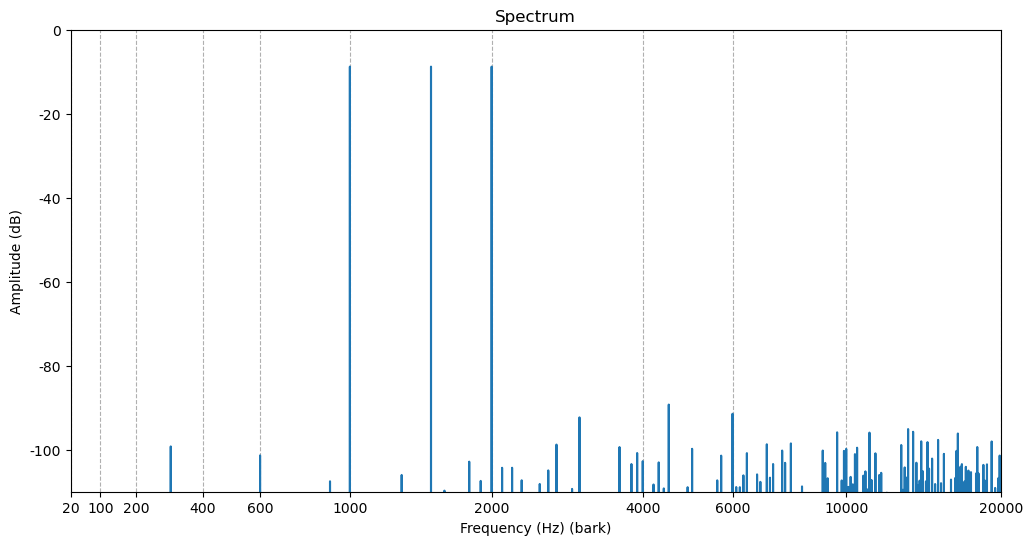

<_io.BufferedRandom name='exports/mixed_audio.wav'>

In [21]:
mixed_audio = generate_sine_wave(1000, 1, amplitude=0.1).overlay(generate_sine_wave(1500, 1, amplitude=0.1)).overlay(generate_sine_wave(2000, 1, amplitude=0.1))
#play(mixed_audio)
plot_fourier_transformation(mixed_audio)
mixed_audio.export("exports/mixed_audio.wav", format="wav")

This produces some noise but if we raise the bitraite that goes away:

Unfortunately soundcards arent easily set up for int32 bitrates. float32 is possible but complicated, and int24 is possible with soundcards but is complicated with numpy arrays. int16 has some noise but is the easiest to work with in this context.

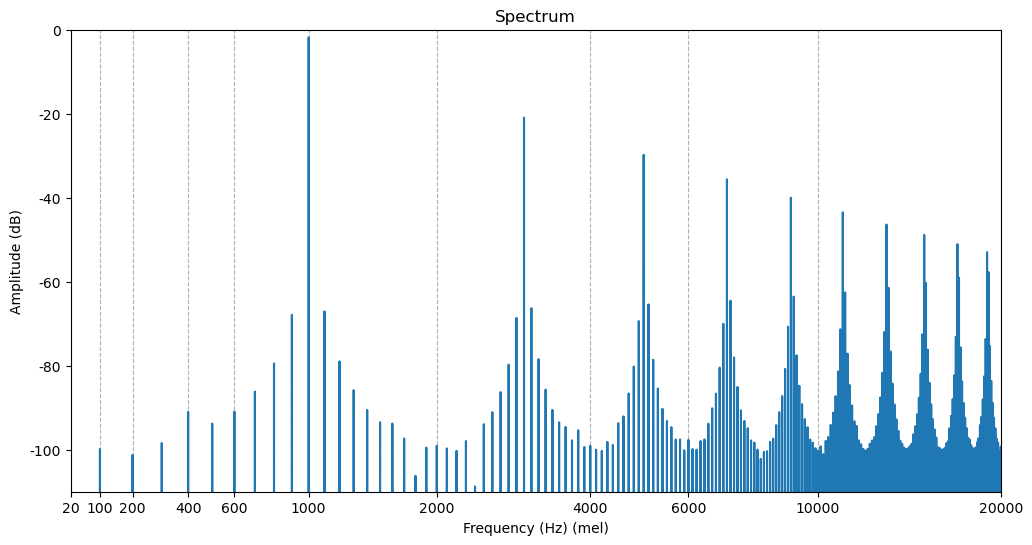

In [22]:
def generate_triangle_wave(frequency, duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate a triangle wave.

    Parameters:
    - frequency: Frequency of the triangle wave in Hz.
    - duration: Duration of the triangle wave in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the triangle wave (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated triangle wave as an AudioSegment object.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = 2 * amplitude * np.abs(2 * (t * frequency - np.floor(t * frequency + 0.5))) - amplitude
    if bitrate == 16:
        waveform = np.int16(waveform * 32767)
    if bitrate == 32:
        waveform = np.int32(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

# Example usage
triangle_wave = generate_triangle_wave(1000, 1)
#play(triangle_wave)
plot_fourier_transformation(triangle_wave, scale='mel')
triangle_wave.export("exports/triangle_wave.wav", format="wav")
del triangle_wave

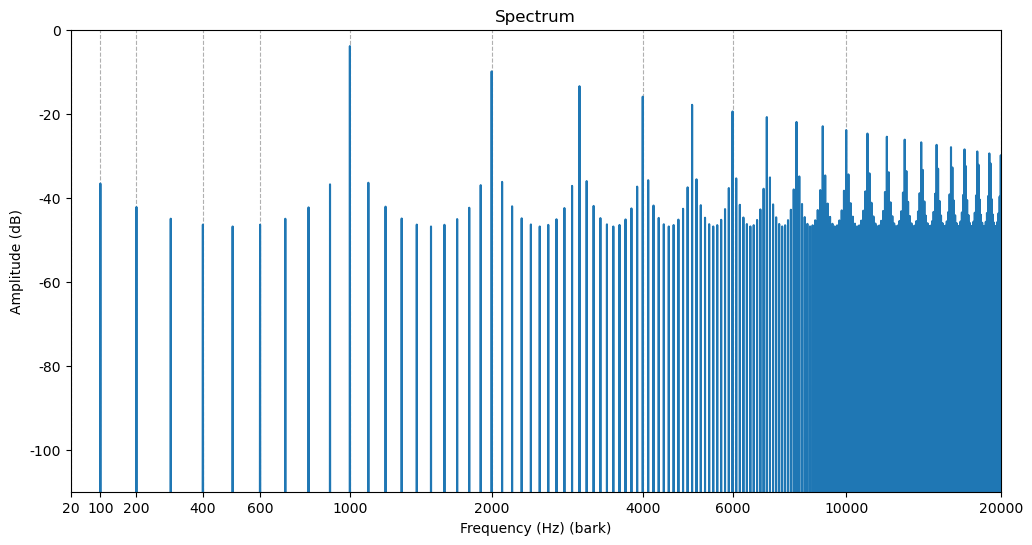

In [23]:
def generate_sawtooth_wave(frequency, duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate a sawtooth wave.

    Parameters:
    - frequency: Frequency of the sawtooth wave in Hz.
    - duration: Duration of the sawtooth wave in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the sawtooth wave (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated sawtooth wave as an AudioSegment object.
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    waveform = 2 * amplitude * (t * frequency - np.floor(t * frequency + 0.5))
    if bitrate == 16:
        waveform = np.int16(waveform * 32767)
    if bitrate == 32:
        waveform = np.int32(waveform * 32767)
    audio = AudioSegment(
        waveform.tobytes(),
        frame_rate=sample_rate,
        sample_width=waveform.dtype.itemsize,
        channels=1
    )
    return audio

# Example usage
sawtooth_wave = generate_sawtooth_wave(1000, 1)
#play(sawtooth_wave)
plot_fourier_transformation(sawtooth_wave)
del sawtooth_wave

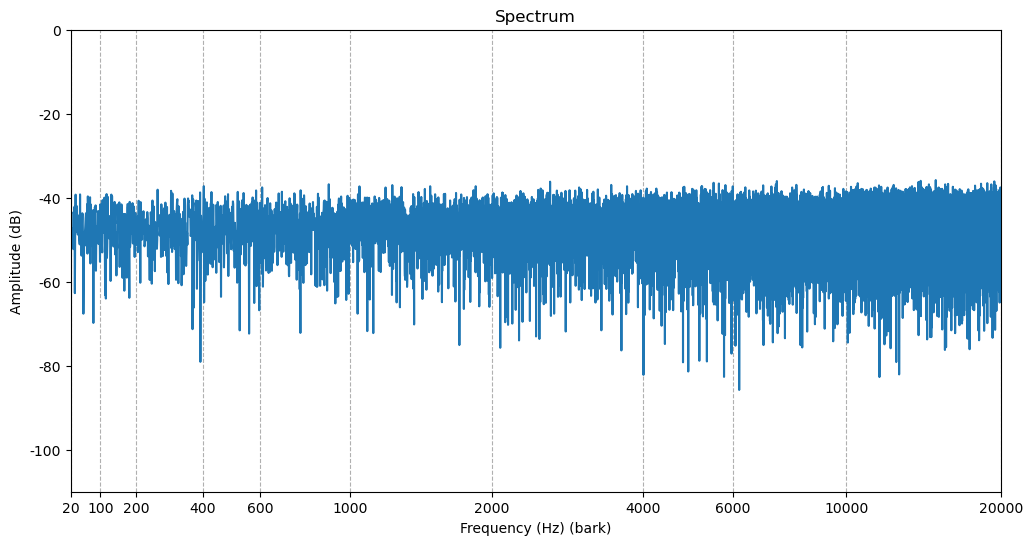

In [24]:
from pydub import AudioSegment
import numpy as np

def generate_white_noise(duration, sample_rate=44100, amplitude=0.5, bitrate=16):
    """
    Generate white noise.

    Parameters:
    - duration: Duration of the white noise in seconds.
    - sample_rate: Sample rate of the audio (default is 44100 Hz).
    - amplitude: Amplitude of the white noise (default is 0.5).
    - bitrate: Bitrate of the audio (default is 16 bits).

    Returns:
    - AudioSegment: The generated white noise as an AudioSegment object.
    """
    # Generate random samples
    samples = np.random.uniform(low=-1.0, high=1.0, size=int(sample_rate * duration))
    if bitrate == 16:
        samples = (samples * amplitude * 32767).astype(np.int16)
    elif bitrate == 32:
        samples = (samples * amplitude * 32767).astype(np.int32)
    
    # Create an AudioSegment
    audio = AudioSegment(
        samples.tobytes(),
        frame_rate=sample_rate,
        sample_width=samples.dtype.itemsize,
        channels=1
    )
    
    return audio

# Example usage
white_noise = generate_white_noise(1, bitrate=16)  # 5 seconds of white noise
#play(white_noise)
plot_fourier_transformation(white_noise)

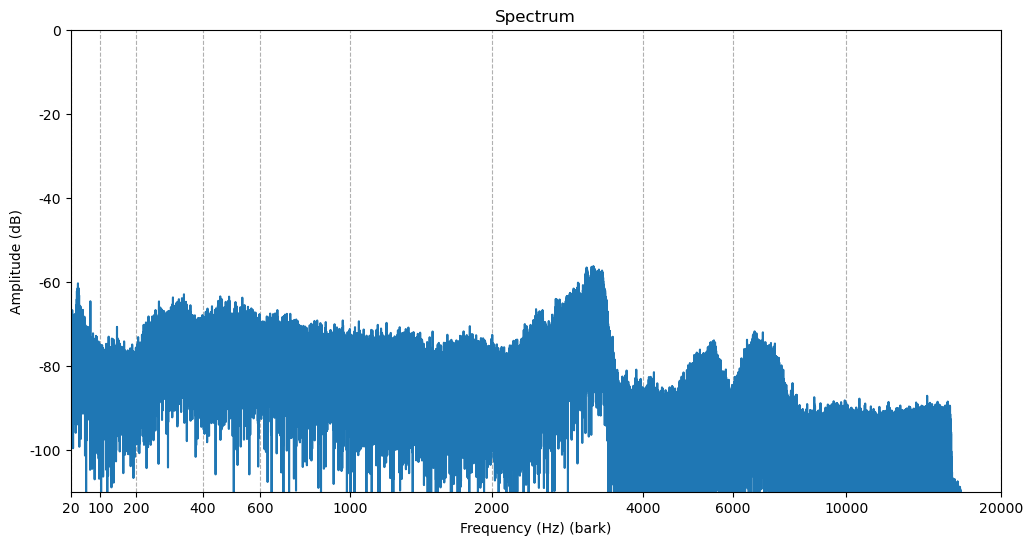

In [25]:
plot_fourier_transformation(bird_sound)

#### Reducing the number of datapoints

i literally cant fucking believe ive been able to just free ball this im so glad ive had the audio experiene ive had. lets make a function to simplify a foyer transformaion into a set of logorithmic results


In [26]:
def group_frequencies_rms(frequencies, freq_signal, scale='bark', min_freq=20, max_freq=20000, num_bins=100):
    freq_bins = None
    scale_function = None
    if scale == 'mel':
        scale_function = hz_to_mel
        inverse_scale_function = mel_to_hz
    if scale == 'bark':
        scale_function = hz_to_bark
        inverse_scale_function = bark_to_hz
    if scale == 'erbs':
        scale_function = hz_to_erbs
        inverse_scale_function = erbs_to_hz
    if scale == 'log':
        freq_bins = cp.logspace(cp.log10(min_freq), cp.log10(max_freq), num=num_bins)
        scale_function = lambda x, _: x
        inverse_scale_function = lambda x, _: x
    if freq_bins is None:
        freq_bins = cp.linspace(scale_function(min_freq), scale_function(max_freq), num=num_bins)
        freq_bins = inverse_scale_function(freq_bins)
    bin_indicies = cp.digitize(frequencies, freq_bins) - 1 
    rms_freq_signal = cp.zeros(len(freq_bins))
    for i in range(len(freq_bins)):
        bin_values = freq_signal[bin_indicies == i]
        rms_freq_signal[i] = -cp.sqrt(cp.mean(bin_values**2))
    return freq_bins, rms_freq_signal
        


In [27]:
def plot_fourier_transformation(sound, scale='bark'):
    frequencies, freq_signal = fourier_transform(sound)
    frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)
    plot_frequencies(frequencies, freq_signal, scale=scale)

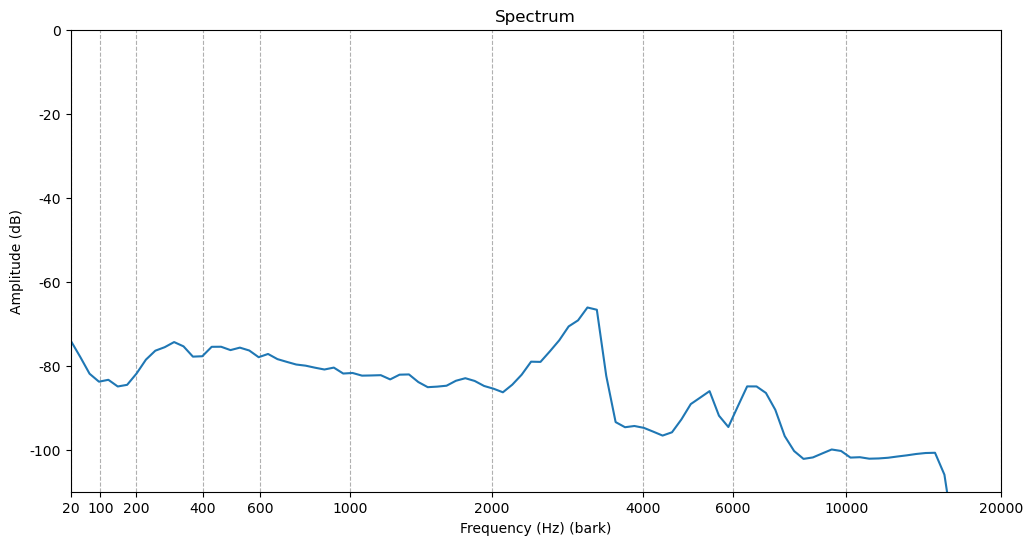

In [28]:
plot_fourier_transformation(bird_sound)

Seeing this brings me feelings of joy no one could possibly understand.

#### Fourier Transform Single Threaded Speed Tests.

Because of the long run times here, we are going to run some benchmarks on the different options we have avaliable to us in terms of performing fourier transformations. The FFT function exists both inside of the `numpy` library as well as the `scipy` library, and as well with access to a cuda capable GPU we can make use of a library called `cupy` that includes most of `numpy` and `scipy` but for running those processes on the GPU with the Cuda Toolkit. Luckly the Cuda Toolkit includes a builtin module for performing fourier transformations on the GPU built in so I have relatively high confidence this will be more performant than running on the CPU.

Micromamba should be able to take care of all of the install for `cupy` with the single command `micromamba install cupy`.

In [29]:
def file_array_size(file):
    return int(df[df.filename == file].array_size.values[0]*(df[df.filename == file].channel.max()+1))

def mono_file_array_size(file):
    return int(df[df.filename == file].array_size.values[0])

def cpu_normalize_signal(signal):
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)
    max_amplitude = np.max(np.abs(signal))
    return signal / max_amplitude

def cpu_magnitude_to_db(signal, epsilon=sys.float_info.epsilon):
    return 20 * np.log10(np.abs(signal) + epsilon)

def cpu_fourier_transform(sound, fft_module=np.fft):
    if sound.channels > 1:
        sound = sound.split_to_mono()[0]
    signal = cpu_normalize_signal(sound.get_array_of_samples())
    signal = fft_module.rfft(signal)
    n = int(sound.frame_count())
    signal = signal / (n/2)
    frequencies = fft_module.rfftfreq(n, 1/sound.frame_rate)
    return frequencies, cpu_magnitude_to_db(signal)

def get_audio(file):
    try:
        sound = AudioSegment.from_file(file, format=mediainfo(file)['format_name'])
        return file, sound
    except:
        print(f'Error loading {file}', end='\033[K')
        return file, None

async def decode_audio(file):
    loop = asyncio.get_event_loop()
    return await loop.run_in_executor(None, get_audio, file)

async def decode_bulk_audio(files):
    tasks = [decode_audio(file) for file in files]
    return await asyncio.gather(*tasks)
  
def df_generator(df):
    prev = None
    for file in df.filename.unique():
        prev = file
        if prev is None:
            continue
        yield prev, file_array_size(file)
    yield prev, None

In [30]:
async def benchmark_fft(iterations, size):
    if iterations * size > len(df):
        print("Not enough data to run the benchmark.")
        print("Try a smaller size or number of iterations.")
    numpy_times = []
    scipy_times = []
    cupy_times = []
    for i in range(iterations):
        test_df = df.sample(size)
        avalable_ram = 4 * 1024 ** 3  # 4 GB

        print()

        print_boundry('Starting NumPy Test')
        start_time = time.time()
        batch_size = 0
        processed_data = 0
        files = []
        generator = df_generator(test_df)
        while True:
            try:
                file, next_file_size = next(generator)
                files.append(file)
                batch_size += file_array_size(file)
                if next_file_size is None or batch_size + next_file_size > avalable_ram:
                    processed_batch_data = 0
                    for filename, sound in await decode_bulk_audio(files):
                        if sound is None:
                            print(f"Error loading sound for {filename}")
                            continue
                        sounds = sound.split_to_mono()
                        for channel in sounds:
                            _, _ = cpu_fourier_transform(channel)
                            processed_batch_data += mono_file_array_size(filename)
                        print_progress_bar(processed_batch_data, batch_size, message=f'{'/'.join(filename.split('/')[-2:])}', convert_to_human_readable=True)
                        processed_data += file_array_size(filename)
                    print('Batch Processed, Total Data Processed:', bytes_to_human_readable(batch_size))
                    batch_size = 0
                    files = []
            except StopIteration:
                break
        numpy_time = time.time() - start_time
        print_boundry('NumPy Test Complete')
        print(f'Processed Data: {bytes_to_human_readable(processed_data)}')
        print(f'Time taken: {numpy_time:.2f} seconds')
        numpy_times.append(numpy_time)

        print()

        print_boundry('Starting SciPy Test')
        start_time = time.time()
        avalable_ram = 4 * 1024 ** 3  # 4 GB
        batch_size = 0
        processed_data = 0
        files = []
        generator = df_generator(test_df)
        while True:
            try:
                file, next_file_size = next(generator)
                files.append(file)
                batch_size += file_array_size(file)
                if next_file_size is None or batch_size + next_file_size > avalable_ram:
                    processed_batch_data = 0
                    for filename, sound in await decode_bulk_audio(files):
                        if sound is None:
                            print(f"Error loading sound for {filename}")
                            continue
                        sounds = sound.split_to_mono()
                        for channel in sounds:
                            _, _ = cpu_fourier_transform(channel, fft_module=sp.fft)
                            processed_batch_data += mono_file_array_size(filename)
                        print_progress_bar(processed_batch_data, batch_size, message=f'{'/'.join(filename.split('/')[-2:])}', convert_to_human_readable=True)
                        processed_data += file_array_size(filename)
                    print('Batch Processed, Total Data Processed:', bytes_to_human_readable(batch_size))
                    batch_size = 0
                    files = []
            except StopIteration:
                break
        scipy_time = time.time() - start_time
        print_boundry('SciPy Test Complete')
        print(f'Processed Data: {bytes_to_human_readable(processed_data)}')
        print(f'Time taken: {scipy_time:.2f} seconds')
        scipy_times.append(scipy_time)

        print()

        print_boundry('Starting CuPy Test')
        start_time = time.time()
        avalable_ram = vram_pool.get_limit() * 0.90  # This is 90% of the 75% limit we set earlier.
        print(f'Available VRAM: {bytes_to_human_readable(avalable_ram)}')
        batch_size = 0
        processed_data = 0
        files = []
        generator = df_generator(test_df)
        while True:
            try:
                file, next_file_size = next(generator)
                files.append(file)
                batch_size += file_array_size(file)
                if next_file_size is None or batch_size + next_file_size > avalable_ram:
                    processed_batch_data = 0
                    for filename, sound in await decode_bulk_audio(files):
                        if sound is None:
                            print(f"Error loading sound for {filename}")
                            continue
                        sounds = sound.split_to_mono()
                        for channel in sounds:
                            _, _ = fourier_transform(channel)
                            processed_batch_data += mono_file_array_size(filename)
                        print_progress_bar(processed_batch_data, batch_size, message=f'{'/'.join(filename.split('/')[-2:])}', convert_to_human_readable=True)
                        processed_data += file_array_size(filename)
                    vram_pool.free_all_blocks() # Free all blocks in the memory pool
                    print('Batch Processed, Total Data Processed:', bytes_to_human_readable(batch_size))
                    batch_size = 0
                    files = []
            except StopIteration:
                break
        cupy_time = time.time() - start_time
        print_boundry('CuPy Test Complete')
        print(f'Processed Data: {bytes_to_human_readable(processed_data)}')
        print(f'Time taken: {cupy_time:.2f} seconds')
        cupy_times.append(cupy_time)
    return numpy_times, scipy_times, cupy_times


In [31]:
benchnmark_df = None
if os.path.exists('exports/i5_100x100_fft_benchmark.csv'):
    benchnmark_df = pd.read_csv('exports/i5_100x100_fft_benchmark.csv')
else:
    numpy_times, scipy_times, cupy_times = await benchmark_fft(100, 100)
    benchnmark_df = pd.DataFrame([numpy_times, scipy_times, cupy_times]).T
    benchnmark_df.columns = ['numpy', 'scipy', 'cupy']
benchnmark_df.to_csv('exports/i5_100x100_fft_benchmark.csv', index=False)

print(f'CuPy Average Time: {benchnmark_df['cupy'].mean():.2f} ± {benchnmark_df['cupy'].std():.2f}')
print(f'SciPy Average Time: {benchnmark_df['scipy'].mean():.2f} ± {benchnmark_df['scipy'].std():.2f}')
print(f'Numpy Average Time: {benchnmark_df['numpy'].mean():.2f} ± {benchnmark_df['numpy'].std():.2f}')
print()
print(f'SciPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['scipy'].mean():.2f}x')
print(f'CuPy Speedup Over SciPy: {benchnmark_df['scipy'].mean() / benchnmark_df['cupy'].mean():.2f}x')
print(f'CuPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['cupy'].mean():.2f}x')


---------------------------------------- Starting NumPy Test ----------------------------------------
[====================================================================================================] - 629.33 MB/629.33 MB - brnthr/XC247259.mp33
Batch Processed, Total Data Processed: 629.33 MB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 629.33 MB
Time taken: 62.18 seconds

---------------------------------------- Starting SciPy Test ----------------------------------------
[====================================================================================================] - 629.33 MB/629.33 MB - brnthr/XC247259.mp33
Batch Processed, Total Data Processed: 629.33 MB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 629.33 MB
Time taken: 56.93 seconds

----------------------------------------- Starting CuPy Test ------------------------------

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 795.89 MB/795.89 MB - semplo/XC447139.mp3
Batch Processed, Total Data Processed: 795.89 MB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 795.89 MB
Time taken: 67.24 seconds

---------------------------------------- Starting SciPy Test ----------------------------------------
[=================================================================================                   ] - 648.05 MB/795.89 MB - lobdow/XC221588.mp33

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 795.89 MB/795.89 MB - semplo/XC447139.mp3
Batch Processed, Total Data Processed: 795.89 MB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 795.89 MB
Time taken: 62.67 seconds

----------------------------------------- Starting CuPy Test -----------------------------------------
Available VRAM: 4.05 GB
[====================================================================================================] - 795.89 MB/795.89 MB - semplo/XC447139.mp33
Batch Processed, Total Data Processed: 795.89 MB
----------------------------------------- CuPy Test Complete -----------------------------------------
Processed Data: 795.89 MB
Time taken: 16.47 seconds

---------------------------------------- Starting NumPy Test ----------------------------------------
[==================================================================

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 760.31 MB/760.31 MB - larspa/XC374093.mp33
Batch Processed, Total Data Processed: 760.31 MB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 760.31 MB
Time taken: 58.53 seconds

---------------------------------------- Starting SciPy Test ----------------------------------------
[===================                                                                                 ] - 147.80 MB/760.31 MB - normoc/XC62791.mp33

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 760.31 MB/760.31 MB - larspa/XC374093.mp33
Batch Processed, Total Data Processed: 760.31 MB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 760.31 MB
Time taken: 54.88 seconds

----------------------------------------- Starting CuPy Test -----------------------------------------
Available VRAM: 4.05 GB
[====================================================================================================] - 760.31 MB/760.31 MB - larspa/XC374093.mp33
Batch Processed, Total Data Processed: 760.31 MB
----------------------------------------- CuPy Test Complete -----------------------------------------
Processed Data: 760.31 MB
Time taken: 14.86 seconds

---------------------------------------- Starting NumPy Test ----------------------------------------
[=================================================================

In [32]:
benchnmark_df = None
if os.path.exists('exports/i5_10x2500_fft_benchmark.csv'):
    benchnmark_df = pd.read_csv('exports/i5_10x2500_fft_benchmark.csv')
else:
    numpy_times, scipy_times, cupy_times = await benchmark_fft(10, 2500)
    benchnmark_df = pd.DataFrame([numpy_times, scipy_times, cupy_times]).T
    benchnmark_df.columns = ['numpy', 'scipy', 'cupy']
benchnmark_df.to_csv('exports/i5_10x2500_fft_benchmark.csv', index=False)

print(f'CuPy Average Time: {benchnmark_df['cupy'].mean():.2f} ± {benchnmark_df['cupy'].std():.2f}')
print(f'SciPy Average Time: {benchnmark_df['scipy'].mean():.2f} ± {benchnmark_df['scipy'].std():.2f}')
print(f'Numpy Average Time: {benchnmark_df['numpy'].mean():.2f} ± {benchnmark_df['numpy'].std():.2f}')
print()
print(f'SciPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['scipy'].mean():.2f}x')
print(f'CuPy Speedup Over SciPy: {benchnmark_df['scipy'].mean() / benchnmark_df['cupy'].mean():.2f}x')
print(f'CuPy Speedup Over Numpy: {benchnmark_df['numpy'].mean() / benchnmark_df['cupy'].mean():.2f}x')


---------------------------------------- Starting NumPy Test ----------------------------------------
[====================================================================================================] - 4.00 GB/4.00 GB - houfin/XC254556.mp3333
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 3.99 GB/3.99 GB - aldfly/XC144675.mp33p3
Batch Processed, Total Data Processed: 3.99 GB
[====================================================================================================] - 4.03 GB/4.03 GB - whtspa/XC329834.mp33p33
Batch Processed, Total Data Processed: 4.03 GB
[====================================================================================================] - 3.99 GB/3.99 GB - easmea/XC406009.mp33p3
Batch Processed, Total Data Processed: 3.99 GB
[====================================================================================================] - 1.04 GB/1.04 GB - a

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - bkhgro/XC420002.mp33
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.00 GB/4.00 GB - easmea/XC370243.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 1.08 GB/1.08 GB - brebla/XC186654.mp33p3
Batch Processed, Total Data Processed: 1.08 GB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 17.07 GB
Time taken: 1594.53 seconds

---------------------------------------- Starting SciPy Test ----------------------------------------
[====================================================================================================] - 4.00 GB/4.00 GB - cangoo/XC473361.mp33p3
Batch Processed, To

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - bkhgro/XC420002.mp33
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.00 GB/4.00 GB - easmea/XC370243.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 1.08 GB/1.08 GB - brebla/XC186654.mp33p3
Batch Processed, Total Data Processed: 1.08 GB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 17.07 GB
Time taken: 1479.27 seconds

----------------------------------------- Starting CuPy Test -----------------------------------------
Available VRAM: 4.05 GB
[====================================================================================================] - 4.04 GB/4.04 GB - brncre/XC244351.m

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - casfin/XC375905.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 1008.97 MB/1008.97 MB - juntit1/XC363345.mp3
Batch Processed, Total Data Processed: 1008.97 MB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 17.04 GB
Time taken: 1504.86 seconds

---------------------------------------- Starting SciPy Test ----------------------------------------
[====================================================================================================] - 4.08 GB/4.08 GB - coohaw/XC494104.mp3333
Batch Processed, Total Data Processed: 4.08 GB
[====================================================================================================] - 3.98 GB/3.98 GB - buggna/XC465623.mp33p3
Batch Proc

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - casfin/XC375905.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 1008.97 MB/1008.97 MB - juntit1/XC363345.mp3
Batch Processed, Total Data Processed: 1008.97 MB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 17.04 GB
Time taken: 1404.88 seconds

----------------------------------------- Starting CuPy Test -----------------------------------------
Available VRAM: 4.05 GB
[====================================================================================================] - 4.08 GB/4.08 GB - coohaw/XC494104.mp3333
Batch Processed, Total Data Processed: 4.08 GB
[====================================================================================================] - 4.02 GB/4.02 GB - normoc/X

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - amerob/XC324394.mp33
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.00 GB/4.00 GB - bawwar/XC137040.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.00 GB/4.00 GB - macwar/XC192524.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 1009.30 MB/1009.30 MB - horlar/XC447701.mp3
Batch Processed, Total Data Processed: 1009.30 MB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 16.99 GB
Time taken: 1640.71 seconds

---------------------------------------- Starting SciPy Test -------

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - amerob/XC324394.mp33
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.00 GB/4.00 GB - bawwar/XC137040.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.00 GB/4.00 GB - macwar/XC192524.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 1009.30 MB/1009.30 MB - horlar/XC447701.mp3
Batch Processed, Total Data Processed: 1009.30 MB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 16.99 GB
Time taken: 1526.26 seconds

----------------------------------------- Starting CuPy Test -------

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 844.05 MB/844.05 MB - cacwre/XC304426.mp33
Batch Processed, Total Data Processed: 844.05 MB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 16.79 GB
Time taken: 1569.79 seconds

---------------------------------------- Starting SciPy Test ----------------------------------------
[====================================================================================================] - 3.99 GB/3.99 GB - chswar/XC195311.mp33p3
Batch Processed, Total Data Processed: 3.99 GB
[====================================================================================================] - 4.01 GB/4.01 GB - scoori/XC265516.mp3333
Batch Processed, Total Data Processed: 4.01 GB
[====================================================================================================] - 4.00 GB/4.00 GB - easmea/XC375065.mp33p3
Batch Process

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 844.05 MB/844.05 MB - cacwre/XC304426.mp33
Batch Processed, Total Data Processed: 844.05 MB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 16.79 GB
Time taken: 1447.86 seconds

----------------------------------------- Starting CuPy Test -----------------------------------------
Available VRAM: 4.05 GB
[====================================================================================================] - 4.04 GB/4.04 GB - yehbla/XC355549.mp33p3
Batch Processed, Total Data Processed: 4.04 GB
[====================================================================================================] - 4.04 GB/4.04 GB - wlswar/XC485987.mp3333
Batch Processed, Total Data Processed: 4.04 GB
[====================================================================================================] - 4.03 GB/4.03 GB - comloo/XC37

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 3.99 GB/3.99 GB - brebla/XC341514.mp33p33
Batch Processed, Total Data Processed: 3.99 GB
[================                                                                                    ] - 664.24 MB/4.00 GB - pinjay/XC215462.mp33

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - pinwar/XC316728.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.05 GB/4.05 GB - gnttow/XC369863.mp33p3
Batch Processed, Total Data Processed: 4.05 GB
[====================================================================================================] - 1000.98 MB/1000.98 MB - gadwal/XC441670.mp3
Batch Processed, Total Data Processed: 1000.98 MB
---------------------------------------- NumPy Test Complete ----------------------------------------
Processed Data: 17.11 GB
Time taken: 1542.46 seconds

---------------------------------------- Starting SciPy Test ----------------------------------------
[====================================================================================================] - 4.10 GB/4.10 GB - snogoo/XC393548.mp33p3
Batch Proce

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 3.99 GB/3.99 GB - brebla/XC341514.mp33p33
Batch Processed, Total Data Processed: 3.99 GB
[================                                                                                    ] - 664.24 MB/4.00 GB - pinjay/XC215462.mp33

/tmp/ipykernel_3132587/1172667171.py:11: RuntimeWarning: invalid value encountered in divide
  return signal / max_amplitude


[====================================================================================================] - 4.00 GB/4.00 GB - pinwar/XC316728.mp33p3
Batch Processed, Total Data Processed: 4.00 GB
[====================================================================================================] - 4.05 GB/4.05 GB - gnttow/XC369863.mp33p3
Batch Processed, Total Data Processed: 4.05 GB
[====================================================================================================] - 1000.98 MB/1000.98 MB - gadwal/XC441670.mp3
Batch Processed, Total Data Processed: 1000.98 MB
---------------------------------------- SciPy Test Complete ----------------------------------------
Processed Data: 17.11 GB
Time taken: 1433.82 seconds

----------------------------------------- Starting CuPy Test -----------------------------------------
Available VRAM: 4.05 GB
[====================================================================================================] - 4.10 GB/4.10 GB - snogoo/XC

# Perform the Bulk Calculation.

In [33]:
# Add columns with the frequency bins
frequencies, freq_signal = fourier_transform(bird_sound)
frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)

# Create a dictionary to hold the new columns
new_columns = {f'{int(freq)}Hz': np.nan for freq in frequencies}

# Convert the dictionary to a DataFrame
new_columns_df = pd.DataFrame(new_columns, index=df.index)

# Concatenate the original DataFrame with the new columns DataFrame
df = pd.concat([df, new_columns_df], axis=1)

df.head()

,rating,ebird_code,channel,date,duration,filename,latitude,sampling_rate,type,elevation,...,13690Hz,14279Hz,14893Hz,15534Hz,16202Hz,16899Hz,17626Hz,18384Hz,19175Hz,20000Hz
0,3.5,aldfly,0,2013-05-25,25.488,data/birdsong-recognition/train_audio/aldfly/X...,44.793,48000,call,220 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,aldfly,0,2013-05-27,36.310,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,aldfly,1,2013-05-27,36.310,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,aldfly,0,2013-05-27,39.236,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,aldfly,1,2013-05-27,39.236,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
if not os.path.exists('exports/audio_features.csv'):
    print_boundry('Starting Audio Processing')
    start_time = time.time()
    avalable_ram = vram_pool.get_limit() * 0.90  # This is 90% of the 75% limit we set earlier.
    print(f'Available VRAM: {bytes_to_human_readable(avalable_ram)}')
    batch_size = 0
    processed_data = 0
    files = []
    generator = df_generator(df)
    while True:
        try:
            file, next_file_size = next(generator)
            files.append(file)
            batch_size += file_array_size(file)
            if next_file_size is None or batch_size + next_file_size > avalable_ram:
                processed_batch_data = 0
                for filename, sound in await decode_bulk_audio(files):
                    if sound is None:
                        print(f"Error loading sound for {filename}")
                        continue
                    sounds = sound.split_to_mono()
                    for i in range(sound.channels):
                        frequencies, freq_signal = fourier_transform(sounds[i])
                        frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)
                        frequencies, freq_signal = frequencies.get(), freq_signal.get()
                        for freq in frequencies:
                            df.loc[(df.filename == filename) & (df.channel == i), f'{int(freq)}Hz'] = freq_signal[frequencies == freq]
                        processed_batch_data += mono_file_array_size(filename)
                        print_progress_bar(processed_batch_data, batch_size, message=f'{'/'.join(filename.split('/')[-2:])}', convert_to_human_readable=True)
                    processed_data += file_array_size(filename)
                vram_pool.free_all_blocks() # Free all blocks in the memory pool
                print(f'Batch Processed, Total Data Processed: {bytes_to_human_readable(processed_data)}/{bytes_to_human_readable(df["array_size"].sum())}')
                print('Estimated Time Remaining:', calculate_time_remaining(start_time, processed_data, df['array_size'].sum()))
                batch_size = 0
                files = []
        except StopIteration:
            break
    print_boundry('Audio Processing Complete')
    print(f'Processed Data: {bytes_to_human_readable(processed_data)}')
    df.to_csv('exports/audio_features.csv', index=False)
    del start_time, avalable_ram, batch_size, processed_data, files, generator, df
else:
    print('Loading audio features')
df = pd.read_csv('exports/audio_features.csv')
df.head()

------------------------------------- Starting Audio Processing -------------------------------------
Available VRAM: 4.05 GB
[====================================================================================================] - 4.03 GB/4.03 GB - amered/XC388173.mp3mp3
Batch Processed, Total Data Processed: 4.03 GB/140.28 GB
Estimated Time Remaining: 02:43:42
[====================================================================================================] - 4.03 GB/4.03 GB - baleag/XC51757.mp33mp3
Batch Processed, Total Data Processed: 8.07 GB/140.28 GB
Estimated Time Remaining: 02:32:52
[====================================================================================================] - 4.05 GB/4.05 GB - bewwre/XC217841.mp33p3
Batch Processed, Total Data Processed: 12.12 GB/140.28 GB
Estimated Time Remaining: 02:31:39
[====================================================================================================] - 4.05 GB/4.05 GB - bkpwar/XC319836.mp33mp3
Batch Proces

,rating,ebird_code,channel,date,duration,filename,latitude,sampling_rate,type,elevation,...,13690Hz,14279Hz,14893Hz,15534Hz,16202Hz,16899Hz,17626Hz,18384Hz,19175Hz,20000Hz
0,3.5,aldfly,0,2013-05-25,25.488,data/birdsong-recognition/train_audio/aldfly/X...,44.793,48000,call,220 m,...,-114.740417,-115.474152,-115.668892,-116.013107,-130.761688,-155.399460,-155.453079,-155.454254,-155.387192,-155.487930
1,4.0,aldfly,0,2013-05-27,36.310,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,-102.042267,-101.842033,-101.859543,-123.234306,-150.910294,-151.103989,-151.018845,-151.072021,-151.050583,-151.064941
2,4.0,aldfly,1,2013-05-27,36.310,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,-102.506180,-102.306938,-102.324348,-123.694992,-151.393143,-151.566650,-151.464447,-151.503632,-151.549072,-151.514771
3,4.0,aldfly,0,2013-05-27,39.236,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,-104.452339,-104.657265,-104.633743,-125.490913,-154.434433,-154.565750,-154.511963,-154.542084,-154.482361,-154.525848
4,4.0,aldfly,1,2013-05-27,39.236,data/birdsong-recognition/train_audio/aldfly/X...,36.1065,44100,"call, song",1700 m,...,-104.733505,-104.938713,-104.913765,-125.801163,-154.748199,-154.861481,-154.861603,-154.789734,-154.828293,-154.810211


# Here i worked on the perform_fourier_transformation.py module.

In [35]:
# Find columns that end with 'Hz'
hz_columns = [col for col in df.columns if col.endswith('Hz')]

# Find rows where any of the 'Hz' columns contain null values
null_rows = df[df[hz_columns].isnull().any(axis=1)]

# Print the number of rows and the rows themselves
print(f'Number of rows with null values in Hz columns: {len(null_rows)}')
null_rows

Number of rows with null values in Hz columns: 408


,rating,ebird_code,channel,date,duration,filename,latitude,sampling_rate,type,elevation,...,13690Hz,14279Hz,14893Hz,15534Hz,16202Hz,16899Hz,17626Hz,18384Hz,19175Hz,20000Hz
111,4.0,aldfly,0,2016-05-28,6.276,data/birdsong-recognition/train_audio/aldfly/X...,44.8234,16000,call,40 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,4.5,amecro,0,2015-02-11,18.338,data/birdsong-recognition/train_audio/amecro/X...,48.4175,22050,call,10 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,4.5,amecro,1,2015-02-11,18.338,data/birdsong-recognition/train_audio/amecro/X...,48.4175,22050,call,10 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
315,4.5,amecro,0,2015-02-13,15.185,data/birdsong-recognition/train_audio/amecro/X...,47.6551,22050,call,10 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,4.5,amecro,1,2015-02-13,15.185,data/birdsong-recognition/train_audio/amecro/X...,47.6551,22050,call,10 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31104,4.5,yerwar,0,2018-06-15,103.996,data/birdsong-recognition/train_audio/yerwar/X...,63.3479,24000,song,900 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31105,4.5,yerwar,1,2018-06-15,103.996,data/birdsong-recognition/train_audio/yerwar/X...,63.3479,24000,song,900 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31146,2.5,yetvir,0,2013-06-16,51.644,data/birdsong-recognition/train_audio/yetvir/X...,42.2136,22050,song,120 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31179,3.0,yetvir,0,2015-04-07,27.533,data/birdsong-recognition/train_audio/yetvir/X...,38.287,22050,song,2 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This is more than I expected, though 412 problem rows in a list of 31 thousnad isnt a bad ratio.

In [36]:
#for index, row in null_rows.iterrows():
#    filename = row['filename']
#    print_boundry(f'Processing {filename}')
#    sound = AudioSegment.from_file(filename, format=mediainfo(filename)['format_name'])
#    sounds = sound.split_to_mono()
#    for i, channel in enumerate(sounds):
#        frequencies, freq_signal = fourier_transform(channel)
#        frequencies, freq_signal = group_frequencies_rms(frequencies, freq_signal)
#        frequencies, freq_signal = frequencies.get(), freq_signal.get()
#        for freq in frequencies:
#            print('Original:', df.loc[(df.filename == filename) & (df.channel == i), f'{int(freq)}Hz'].values[0])
#            print('New:', freq_signal[frequencies == freq])
#            df.loc[(df.filename == filename) & (df.channel == i), f'{int(freq)}Hz'] = freq_signal[frequencies == freq]

for index, row in null_rows.iterrows():
    filename = row.filename
    print_boundry(f'Checking {filename}')
    print('Sample Rate:', row.sampling_rate)
    print('Nyquist Frequency:', row.sampling_rate / 2)

----------------- Checking data/birdsong-recognition/train_audio/aldfly/XC319017.mp3 -----------------
Sample Rate: 16000
Nyquist Frequency: 8000.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC233496.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC233496.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC289011.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amecro/XC289011.mp3 -----------------
Sample Rate: 22050
Nyquist Frequency: 11025.0
----------------- Checking data/birdsong-recognition/train_audio/amekes/XC127418.mp3 -----------------
Sample Rate: 24000
Nyquist Frequency: 12000.0
----------------- Checking data/birdsong-recognition/train_audio/amekes/XC127418.mp3 -----------------
Samp

After trying to reperform the fourier transformations and not getting a different result, I analized one of the problem files with an audio editor and found the file had am abnormally low sample rate. If the sample rate is too low it is impossible to replicate high frequency sounds, the highest frequency possible in an audio file is exactly one half the sample rate, which would be equivelant to having one sample on each phase of the wave. All of my code normalizes the range to between 20Hz and 20kHz, but some files are not able to replicate some of those frequencies and result in NaN for those frequency bins. This makes me inclined too look at what sample rates we have.

In [37]:
print(df.sampling_rate.value_counts())

sampling_rate
44100    19554
48000    11317
22050      170
32000      100
24000       91
16000       37
11025        5
8000         2
Name: count, dtype: int64


This is actually a quite surprsing spread. 44.1kHz is the standard for most things like CD's, 48kHz is the standard for video. Most other sample rates I have seen are integer multiples of one of those two numbers, ie 96kHz, 88.2kH, ect. I have never seen files with sample rates like some of these, but they should still mostly be capable of producing enough information to be useful in some cases. A sample rate of 32kHz produces a Nyquist Frequency of 16kHz, and that should be enough information to be useful to the model. I expect many of the files with higher sample rates may already have many of the >16kHz frequencies "rolled off" by mp3 compression or as an intentional decision by an audio engineer to remove excess unhelpful noise.

The 24kHz and 22.05kHz files concern me more, with Nyquist frequencies closer to 10kHz. They may contain enough information to hear the birdcall, but they may confuse the model a little if we were to train off of them.

Anything below 20kHz feels like it cant be very useful to us. Too many frequencies would be unaccounted for.

I will set the 32kHz files to fill the NaN values with -150.0 (remember these bins are measured in decebels), and I will drop any row with a sample rate below 32kHz.

In [38]:
# Remove rows with a sampling rate below 32000
df = df[df.sampling_rate >= 32000]

# Fill null values in files with sample rate of 32000
for index, row in df[df.sampling_rate == 32000].iterrows():
    for col in hz_columns:
        # if the value is null, fill it with -150.0
        if pd.isnull(row[col]):
            df.loc[index, col] = -150.0

df[df.isnull().any(axis=1)]

,rating,ebird_code,channel,date,duration,filename,latitude,sampling_rate,type,elevation,...,13690Hz,14279Hz,14893Hz,15534Hz,16202Hz,16899Hz,17626Hz,18384Hz,19175Hz,20000Hz
6492,2.5,buwwar,1,2015-05-13,209.607,data/birdsong-recognition/train_audio/buwwar/X...,40.9999,44100,"male, song",200 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6494,3.0,buwwar,1,2016-05-23,110.028,data/birdsong-recognition/train_audio/buwwar/X...,40.9999,44100,"male, song",200 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21984,5.0,pinjay,1,2015-01-25,24.947,data/birdsong-recognition/train_audio/pinjay/X...,37.8853,44100,"call, includes what I call ""metalic"" calls",2300 m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When looking at the remining weird files with an audio analysis tool, most of them are simply the result of a stereo file only containing one track of audio. `/buwwar/XC481834.mp3`, `/buwwar/XC481837.mp3`, and `/pinjay/XC215462.mp3` can all be removed because they actually contain no audio data.

In [39]:
df = df.dropna(subset=['20Hz'])
df[df.isnull().any(axis=1)]

,rating,ebird_code,channel,date,duration,filename,latitude,sampling_rate,type,elevation,...,13690Hz,14279Hz,14893Hz,15534Hz,16202Hz,16899Hz,17626Hz,18384Hz,19175Hz,20000Hz


The only remaining file that is a problem is `/eucdov/XC505275.mp3` where both the left and right channels contain a null value. When opening the file there was no obvious reason why it was causing problems and most of the values are not null.

In [40]:
'''
def plot_frequencies(frequencies, fourier, ax=None, title='Spectrum', xlabel='Frequency (Hz)', ylabel='Amplitude'):
    if ax:
        ax.plot(frequencies, np.abs(fourier))
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale('log')
        ax.set_xlim(20, 20000)
        ax.set_xticks([40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000], 
            [40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])
        ax.tick_params(axis='x', rotation=90)
        ax.grid(True, which="both", axis='x', ls="--")
        return
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, np.abs(fourier))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale('log')
    plt.xlim(20, 20000)
    plt.xticks([40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000], 
            [40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])
    plt.grid(True, which="both", axis='x', ls="--")
    plt.show()
'''

'\ndef plot_frequencies(frequencies, fourier, ax=None, title=\'Spectrum\', xlabel=\'Frequency (Hz)\', ylabel=\'Amplitude\'):\n    if ax:\n        ax.plot(frequencies, np.abs(fourier))\n        ax.set_title(title)\n        ax.set_xlabel(xlabel)\n        ax.set_ylabel(ylabel)\n        ax.set_xscale(\'log\')\n        ax.set_xlim(20, 20000)\n        ax.set_xticks([40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000], \n            [40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])\n        ax.tick_params(axis=\'x\', rotation=90)\n        ax.grid(True, which="both", axis=\'x\', ls="--")\n        return\n    plt.figure(figsize=(12, 6))\n    plt.plot(frequencies, np.abs(fourier))\n    plt.title(title)\n    plt.xlabel(xlabel)\n    plt.ylabel(ylabel)\n    plt.xscale(\'log\')\n    plt.xlim(20, 20000)\n    plt.xticks([40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000], \n            [40, 100, 200, 400, 600, 1000, 2000, 4000, 6000, 10000, 20000])\n    plt.grid(True

In [41]:
'''
def plot_cached_fourier_transformations(df, cols=3):
    if len(df) > 100:
        print("Too many rows to plot")
        return
    rows = (len(df) + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()

    count = 0
    for i, row in df.iterrows():
        frequency_bins = [column for column in row.index if column.endswith("Hz")]
        amplitudes = row[frequency_bins].values
        frequencies = [int(column[:-2]) for column in frequency_bins]
        plot_frequencies(frequencies, amplitudes, ax=axes[count], title=f'{row.ebird_code}/{row.filename}')
        count += 1

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
'''

'\ndef plot_cached_fourier_transformations(df, cols=3):\n    if len(df) > 100:\n        print("Too many rows to plot")\n        return\n    rows = (len(df) + cols - 1) // cols\n\n    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))\n    axes = axes.flatten()\n\n    count = 0\n    for i, row in df.iterrows():\n        frequency_bins = [column for column in row.index if column.endswith("Hz")]\n        amplitudes = row[frequency_bins].values\n        frequencies = [int(column[:-2]) for column in frequency_bins]\n        plot_frequencies(frequencies, amplitudes, ax=axes[count], title=f\'{row.ebird_code}/{row.filename}\')\n        count += 1\n\n    # Hide any unused subplots\n    for j in range(i + 1, len(axes)):\n        fig.delaxes(axes[j])\n\n    plt.tight_layout()\n    plt.show()\n    \n'

In [42]:
#plot_cached_fourier_transformations(df.sample(9))

This display has shown the need to normalize the scale on the y axis. Some values are between 1 and 10 and some are between 0 and 100,000. We will iterate through each row and normalize the scale such that all values lie beween 0 and 1.

In [43]:
'''
def normalize_scale(row):
    index, row = row[0], row[1]
    frequency_columns = [column for column in row.index if column.endswith("Hz")]
    frequencies = [int(column[:-2]) for column in frequency_columns]
    amplitudes = row[frequency_columns].values
    max_amplitude = np.max(amplitudes)
    for i, frequency in enumerate(frequencies):
        setattr(row, f'{frequency}Hz', amplitudes[i] / max_amplitude)
    del frequency_columns, frequencies, amplitudes, max_amplitude
    return index, row

for i, row in df.iterrows():
    #i, row = normalize_scale((i, row))
    df.loc[i] = row
    print(f'{i} of {len(df)}', end='\r')

plot_cached_fourier_transformations(df)
'''

'\ndef normalize_scale(row):\n    index, row = row[0], row[1]\n    frequency_columns = [column for column in row.index if column.endswith("Hz")]\n    frequencies = [int(column[:-2]) for column in frequency_columns]\n    amplitudes = row[frequency_columns].values\n    max_amplitude = np.max(amplitudes)\n    for i, frequency in enumerate(frequencies):\n        setattr(row, f\'{frequency}Hz\', amplitudes[i] / max_amplitude)\n    del frequency_columns, frequencies, amplitudes, max_amplitude\n    return index, row\n\nfor i, row in df.iterrows():\n    #i, row = normalize_scale((i, row))\n    df.loc[i] = row\n    print(f\'{i} of {len(df)}\', end=\'\r\')\n\nplot_cached_fourier_transformations(df)\n'

## Now that that worked, lets take a look at our resulting dataset.

The first thing I want to make is a function that takes the dataframe and a column to analize. Inside the function the dataframe will be split by each unique value in the column listed, and each of those dataframes will then display a heatmap of the average values of the foyer transformations in the category. To start we will make a standalone function that will print the heatmap given a any dataframe, and we will test it by passing a dataframe with only `ebird_code == 'aldfly'`

In [44]:
'''
def plot_frequency_heatmap(df):
    # Extract columns that end with "Hz"
    frequency_bins = [column for column in df.columns if column.endswith("Hz")]

    # Initialize an empty list to store the frequency data
    frequency_data = []

    # Compute the histogram for each frequency bin
    for column in frequency_bins:
        col_data = df[column].values
        hist, _ = np.histogram(col_data, bins=100, range=(0, 1))
        print(hist)
        frequency_data.append(hist)

    # Rotate the data to have the frequencies as the columns again
    heatmap_data = np.array(frequency_data).T


    # Plot the 2D heatmap
    plt.figure(figsize=(20, 10))
    plt.imshow(heatmap_data, aspect='auto', cmap='viridis')
    plt.colorbar(label='Frequency')
    plt.xlabel('Frequency Bins')
    plt.ylabel('Histogram Bins')
    plt.title('2D Heatmap of Birdsong Amplitude Frequencies Across Frequency Bins')
    plt.xticks(ticks=range(len(frequency_bins)), labels=frequency_bins, rotation=90)
    plt.show()
'''

'\ndef plot_frequency_heatmap(df):\n    # Extract columns that end with "Hz"\n    frequency_bins = [column for column in df.columns if column.endswith("Hz")]\n\n    # Initialize an empty list to store the frequency data\n    frequency_data = []\n\n    # Compute the histogram for each frequency bin\n    for column in frequency_bins:\n        col_data = df[column].values\n        hist, _ = np.histogram(col_data, bins=100, range=(0, 1))\n        print(hist)\n        frequency_data.append(hist)\n\n    # Rotate the data to have the frequencies as the columns again\n    heatmap_data = np.array(frequency_data).T\n\n\n    # Plot the 2D heatmap\n    plt.figure(figsize=(20, 10))\n    plt.imshow(heatmap_data, aspect=\'auto\', cmap=\'viridis\')\n    plt.colorbar(label=\'Frequency\')\n    plt.xlabel(\'Frequency Bins\')\n    plt.ylabel(\'Histogram Bins\')\n    plt.title(\'2D Heatmap of Birdsong Amplitude Frequencies Across Frequency Bins\')\n    plt.xticks(ticks=range(len(frequency_bins)), labels=fr

In [45]:
#plot_frequency_heatmap(df)

In [46]:
'''
min_freq = 20
max_freq = 20000
num_bins = 120

# Calculate the ratio
ratio = (max_freq / min_freq) ** (1 / (num_bins - 1))

# Calculate the next two values after 20000
next_value_1 = max_freq * ratio
next_value_2 = next_value_1 * ratio

print(f"Next value 1: {next_value_1}")
print(f"Next value 2: {next_value_2}")
'''

'\nmin_freq = 20\nmax_freq = 20000\nnum_bins = 120\n\n# Calculate the ratio\nratio = (max_freq / min_freq) ** (1 / (num_bins - 1))\n\n# Calculate the next two values after 20000\nnext_value_1 = max_freq * ratio\nnext_value_2 = next_value_1 * ratio\n\nprint(f"Next value 1: {next_value_1}")\nprint(f"Next value 2: {next_value_2}")\n'

In [47]:
'''
def print_progress_bar(iteration, length, message=''):
    progress = iteration / length
    progress_percent = int(progress * 100)
    
    # Determine color based on progress
    if progress_percent < 25:
        color = '\033[91m'  # Red
    elif progress_percent < 60:
        color = '\033[94m'  # Orange
    elif progress_percent < 90:
        color = '\033[93m'  # Yellow
    else:
        color = '\033[92m'  # Green

    bar = color + '=' * progress_percent + '\033[0m' + ' ' * (100 - progress_percent)
    print(f'\r[{bar}] - {iteration}/{length}', end='')
    if message:
        print(f' - {message}', end='')
    if progress_percent == 100:
        print()
        print('\033[?25h', end='')  # Show cursor
    else:
        print('\033[?25h', end='')  # Show cursor after each update

from time import sleep

for i in range(1000):
    sleep(0.01)
    print_progress_bar(i, 1000)
'''

"\ndef print_progress_bar(iteration, length, message=''):\n    progress = iteration / length\n    progress_percent = int(progress * 100)\n    \n    # Determine color based on progress\n    if progress_percent < 25:\n        color = '\x1b'  # Red\n    elif progress_percent < 60:\n        color = '\x1b'  # Orange\n    elif progress_percent < 90:\n        color = '\x1b'  # Yellow\n    else:\n        color = '\x1b'  # Green\n\n    bar = color + '=' * progress_percent + '\x1b' + ' ' * (100 - progress_percent)\n    print(f'\r[{bar}] - {iteration}/{length}', end='')\n    if message:\n        print(f' - {message}', end='')\n    if progress_percent == 100:\n        print()\n        print('\x1b[?25h', end='')  # Show cursor\n    else:\n        print('\x1b[?25h', end='')  # Show cursor after each update\n\nfrom time import sleep\n\nfor i in range(1000):\n    sleep(0.01)\n    print_progress_bar(i, 1000)\n"